In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pynwb

# Define the path to the folder
folder_path = '000017/sub-Cori/'

# Check if the folder exists and list its contents
if os.path.exists(folder_path):
    contents = os.listdir(folder_path)
else:
    contents = None

contents

['sub-Cori_ses-20161214T120000.nwb',
 'sub-Cori_ses-20161218T120000.nwb',
 'sub-Cori_ses-20161217T120000.nwb']

In [5]:
def open_nwb_data(nwb_file_path):
    """
    Opens an NWB file and returns the NWB data object.

    Parameters:
    nwb_file_path (str): The file path of the NWB file.

    Returns:
    NWBData: An object containing the NWB data.
    """
    with pynwb.NWBHDF5IO(nwb_file_path, 'r') as io:
        return io.read()


In [6]:
nwb_file_path = f'{folder_path}/{contents[0]}'  # Replace with your NWB file path
nwb_data = open_nwb_data(nwb_file_path)
nwb_data

root pynwb.file.NWBFile at 0x139786428825296
Fields:
  acquisition: {
    lickPiezo <class 'pynwb.base.TimeSeries'>,
    wheel_position <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    0 <class 'pynwb.device.Device'>,
    1 <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Probe1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Probe2 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Large-scale Neuropixels recordings across brain regions of mice during a head-fixed visual discrimination task. 
  experimenter: ['Nick Steinmetz']
  file_create_date: [datetime.datetime(2019, 11, 26, 13, 54, 42, 972670, tzinfo=tzoffset(None, -28800))]
  identifier: Cori_2016-12-14
  institution: University College London
  intervals: {
    spontaneous <class 'pynwb.epoch.TimeIntervals'>,
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: The Carandini and Harris Lab
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['DOI 10.1038/s41586-019-1787-x']
  session_description: Neuropixels recording during visual discrimination in awake mice.
  session_start_time: 2016-12-14 12:00:00+00:00
  stimulus: {
    passive_beeps <class 'pynwb.base.TimeSeries'>,
    passive_click_times <class 'pynwb.base.TimeSeries'>,
    passive_left_contrast <class 'pynwb.base.TimeSeries'>,
    passive_right_contrast <class 'pynwb.base.TimeSeries'>,
    passive_white_noise <class 'pynwb.base.TimeSeries'>,
    receptive_field_mapping_sparse_noise <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at 0x139786428812688
Fields:
  age: 77 days
  description: strain: C57Bl6/J
  genotype: tetO-G6s x CaMK-tTA
  sex: F
  species: Mus musculus
  subject_id: Cori

  timestamps_reference_time: 2016-12-14 12:00:00+00:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>
  units: units <class 'pynwb.misc.Units'>

In [98]:
def get_spiking_data(nwb_data, neuron_indices, trial_number,trial_start_time, trial_end_time):
    """
    Retrieves spike times for specified neurons during a specific trial.

    Parameters:
    nwb_data (NWBData): The NWB data object.
    neuron_indices (list of int): List of neuron indices to plot.
    trial_number (int): The trial number of interest.

    Returns:
    tuple: A tuple containing a dictionary with neuron indices as keys and spike times as values,
           the trial start time, and the trial end time.
    """
    if trial_number is not None:
        trial_start_time = nwb_data.trials['start_time'][trial_number]
        trial_end_time = nwb_data.trials['stop_time'][trial_number]
    spike_data = {}

    if nwb_data.units:
        for i in neuron_indices:
            unit = nwb_data.units[i]
            spike_times = unit['spike_times'][:].values[0]
            trial_spike_times = spike_times[(spike_times >= trial_start_time) & (spike_times <= trial_end_time)]
            spike_data[i] = trial_spike_times
            

    return spike_data, trial_start_time, trial_end_time


In [99]:
import matplotlib.pyplot as plt

def plot_spike_times(spike_data, trial_start_time, trial_end_time):
    """
    Plots the spike times of neurons.

    Parameters:
    spike_data (dict): A dictionary containing spike times.
    trial_number (int): The trial number.
    trial_start_time (float): Start time of the trial.
    trial_end_time (float): End time of the trial.
    """
    fig, ax = plt.subplots()

    for neuron_index, spikes in spike_data.items():
        ax.plot(spikes, [neuron_index] * len(spikes), '|', markersize=10)

    ax.set_xlim(trial_start_time, trial_end_time)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neurons')
    ax.set_title(f'Spike Times for Trial {trial_number}')

    plt.show()


/opt/conda/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: IntervalSeries 'wheel_moves': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "


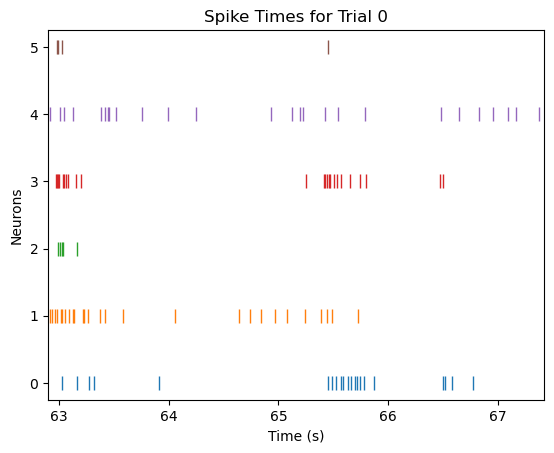

In [100]:
import pynwb

def perform_analysis(nwb_file_path, neuron_indices, trial_number = None, trial_start_time = None, trial_end_time=None):
    """
    Performs analysis on the NWB file.

    Parameters:
    nwb_file_path (str): The file path of the NWB file.
    neuron_indices (list of int): List of neuron indices to plot.
    trial_number (int): The trial number of interest.
    """
    with pynwb.NWBHDF5IO(nwb_file_path, 'r') as io:
        nwb_data = io.read()

        # Get spiking data
        spiking_data, trial_start_time, trial_end_time = get_spiking_data(nwb_data, neuron_indices, trial_number,trial_start_time, trial_end_time)

        # Plot the data
        if spiking_data:
            plot_spike_times(spiking_data, trial_start_time, trial_end_time)

# Now you can call this function with the file path, neuron indices, and trial number
perform_analysis(nwb_file_path, [0, 1, 2, 3, 4, 5], 0)


In [101]:
def get_interval_times_from_nwb(nwb_file_path, interval_type):
    """
    Opens an NWB file and retrieves start and stop times for specified intervals.

    Parameters:
    nwb_file_path (str): The file path of the NWB file.
    interval_type (str): Type of interval ('spontaneous' or 'trials').

    Returns:
    tuple of lists: Two lists, one containing the start times and another containing the stop times for each interval.
    """
    if interval_type not in ['spontaneous', 'trials']:
        raise ValueError("interval_type must be 'spontaneous' or 'trials'")

    with pynwb.NWBHDF5IO(nwb_file_path, 'r') as io:
        nwb_data = io.read()

        try:
            intervals = nwb_data.intervals[interval_type]
        except KeyError:
            raise ValueError(f"Interval type '{interval_type}' not found in the data.")

        if intervals is None or len(intervals) == 0:
            raise ValueError(f"No data found for interval type '{interval_type}'")

        try:
            start_times = intervals['start_time'].data[:]
            stop_times = intervals['stop_time'].data[:]
        except Exception as e:
            raise RuntimeError(f"Error extracting data: {e}")

    return start_times, stop_times


In [102]:
spontaneous_times = get_interval_times_from_nwb(nwb_file_path, 'spontaneous')

/opt/conda/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: IntervalSeries 'wheel_moves': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "


In [103]:
trial_times = get_interval_times_from_nwb(nwb_file_path, 'trials')

/opt/conda/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: IntervalSeries 'wheel_moves': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "


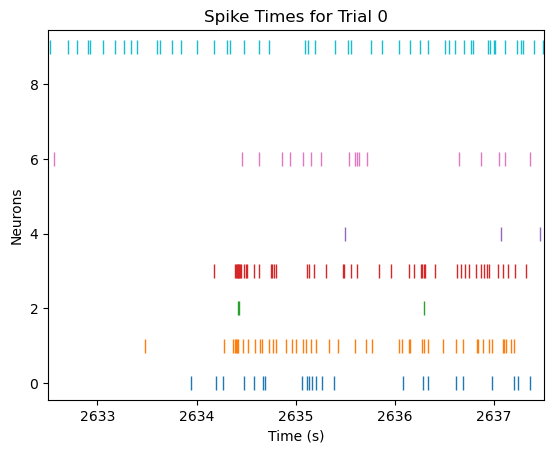

In [118]:
perform_analysis(nwb_file_path, 
                 neuron_indices = list(range(10)) , 
                 trial_start_time = spontaneous_times[0][3], trial_end_time=spontaneous_times[0][3] + 5 )

/opt/conda/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: IntervalSeries 'wheel_moves': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "


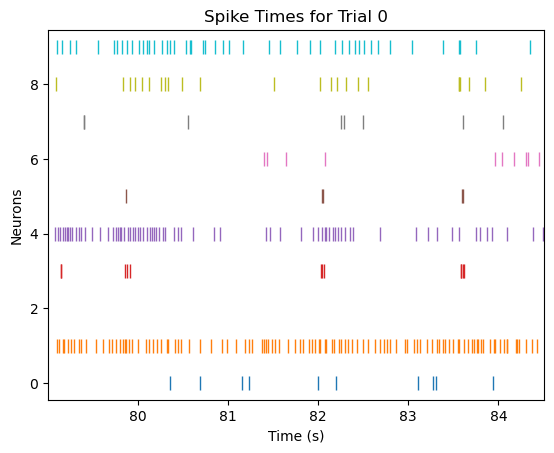

In [114]:
perform_analysis(nwb_file_path, 
                 neuron_indices = list(range(10)) , 
                 trial_start_time = trial_times[0][3], trial_end_time=trial_times[1][3])

In [119]:
def get_phy_annotations_data(nwb_data, neuron_indices, trial_number, trial_start_time=None, trial_end_time=None):
    """
    Retrieves physiological annotations for specified neurons during a specific trial.

    Parameters:
    nwb_data (NWBData): The NWB data object.
    neuron_indices (list of int): List of neuron indices.
    trial_number (int): The trial number of interest.

    Returns:
    tuple: A tuple containing a dictionary with neuron indices as keys and physiological annotations as values,
           the trial start time, and the trial end time.
    """
    # If trial_number is provided, override the start and end times
    if trial_number is not None:
        trial_start_time = nwb_data.trials['start_time'][trial_number]
        trial_end_time = nwb_data.trials['stop_time'][trial_number]

    phy_annotations_data = {}

    # Check if the units data is available
    if 'phy_annotations' in nwb_data.units:
        for i in neuron_indices:
            unit = nwb_data.units[i]
            phy_annotations = unit.get('phy_annotations', None)
            if phy_annotations is not None:
                # Optionally, you can filter or process phy_annotations based on trial_start_time and trial_end_time
                phy_annotations_data[i] = phy_annotations

    return phy_annotations_data, trial_start_time, trial_end_time


In [121]:
with pynwb.NWBHDF5IO(nwb_file_path, 'r') as io:
        nwb_data = io.read()
        phy_annotations_data, trial_start_time, trial_end_time =get_phy_annotations_data(nwb_data, neuron_indices, 0)

/opt/conda/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: IntervalSeries 'wheel_moves': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
